# Bike-Sharing Data Clustering Analysis (Day-Level)

## 1. Objective

### The goal of this analysis is to identify distinct usage patterns in the bike-sharing dataset using numeric features only.
### We aim to:

- Segment days into clusters based on usage patterns.
- Understand how features like temperature, humidity, season, and weather influence daily bike rentals.
- Validate cluster choice (k) using multiple clustering methods.

In [93]:
# Core libraries
import pandas as pd
import numpy as np
import seaborn as sns

# Machine learning tools
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.ensemble import IsolationForest

# Visualization
import matplotlib.pyplot as plt
from bokeh.plotting import figure, show, output_notebook
from bokeh.models import ColumnDataSource, HoverTool
from bokeh.palettes import Category10

# Activate notebook output
output_notebook()

Loading BokehJS ...

## 2. Data Preparation
- We used the day.csv dataset.

- Selected numeric features only to simplify clustering and avoid encoding text variables.

Selected features:

- season, yr, mnth, holiday, weekday, workingday, weathersit, temp, atemp, hum, windspeed, cnt

- Applied StandardScaler to normalize features (zero mean, unit variance) — required for PCA and K-Means.

In [46]:
day = pd.read_csv("day.csv")
print("Day dataset shape:", day.shape)
numeric_features = ['season', 'yr', 'mnth', 'holiday', 'weekday', 'workingday', 'weathersit', 'temp', 'atemp', 'hum', 'windspeed', 'cnt']

day_numeric = day[numeric_features].copy()
day_numeric.head()

Day dataset shape: (731, 16)


,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt
0,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,985
1,1,0,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,801
2,1,0,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309,1349
3,1,0,1,0,2,1,1,0.200000,0.212122,0.590435,0.160296,1562
4,1,0,1,0,3,1,1,0.226957,0.229270,0.436957,0.186900,1600


## 3. Dimensionality Reduction (PCA)
- Applied Principal Component Analysis (PCA) to reduce dimensionality from 12 features → 2 components.
- Explained variance ratio: The first two components capture a large portion of variance, making visualization feasible.

In [47]:
scaler = StandardScaler()
day_scaled = scaler.fit_transform(day_numeric)

# Check shape
print("Scaled data shape:", day_scaled.shape)

pca = PCA(n_components=2)
day_pca = pca.fit_transform(day_scaled)

# Add PCA columns to DataFrame safely
day_numeric['PCA1'] = day_pca[:, 0]
day_numeric['PCA2'] = day_pca[:, 1]

print("Explained variance ratio by PCA components:", pca.explained_variance_ratio_)
day_numeric[['PCA1','PCA2']].head()

Scaled data shape: (731, 12)
Explained variance ratio by PCA components: [0.26498318 0.15853591]


,PCA1,PCA2
0,-2.654418,1.369899
1,-3.025449,0.863593
2,-3.749074,-1.006196
3,-3.268743,-0.267695
4,-3.318555,-0.988532


## 4. Elbow Method
- plot the Within-Cluster Sum of Squares (WCSS) for different k values.
- Look for the “elbow” point where adding more clusters doesn’t significantly reduce WCSS.

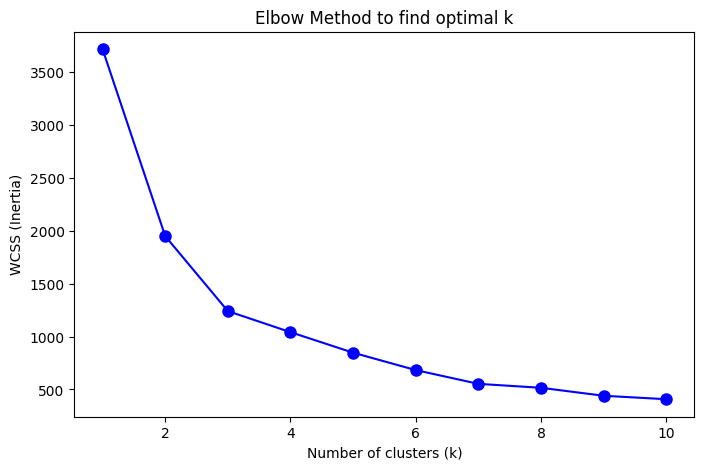

In [48]:
from sklearn.cluster import KMeans
wcss = []
K_range = range(1, 11)  # test k from 1 to 10

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(day_pca)  # use PCA-reduced data
    wcss.append(kmeans.inertia_)

plt.figure(figsize=(8,5))
plt.plot(K_range, wcss, 'bo-', markersize=8)
plt.xlabel('Number of clusters (k)')
plt.ylabel('WCSS (Inertia)')
plt.title('Elbow Method to find optimal k')
plt.show()

## 5. Apply K-Means with Chosen k
- The score can range from -1 to +1.
- A score close to +1 means the data point fits very well in its own cluster and is far from others.
- A score close to 0 means the data point is between clusters or the clusters are overlapping.
- A score close to -1 means the data point is in the wrong cluster.

In [50]:
best_k = 5
kmeans = KMeans(n_clusters=best_k, random_state=42)
day_numeric['cluster'] = kmeans.fit_predict(day_pca)

# Check cluster distribution
print(day_numeric['cluster'].value_counts())

cluster
3    204
4    200
2    123
1    108
0     96
Name: count, dtype: int64


### Output study:
- Cluster 3 has 204 days
- Cluster 4 has 200 days
- Cluster 2 has 123 days
- Cluster 1 has 108 days
- Cluster 0 has 96 days

Rows from the dataset fall into each cluster after running K-Means.It's likely cluster 3 (204 days) might correspond to typical high-demand days, while cluster 0 (96 days) are rare or extreme low-demand days.

## 6. Silhouette Score
- The score can range from -1 to +1.
- A score close to +1 means the data point fits very well in its own cluster and is far from others.
- A score close to 0 means the data point is between clusters or the clusters are overlapping.
- A score close to -1 means the data point is in the wrong cluster.

0.35682342952282947
Silhouette Score for k=5: 0.357
K = 2 and Score = 0.46
K = 3 and Score = 0.42
K = 4 and Score = 0.35
K = 5 and Score = 0.36
K = 6 and Score = 0.36
K = 7 and Score = 0.37
K = 8 and Score = 0.35
K = 9 and Score = 0.37
K = 10 and Score = 0.34


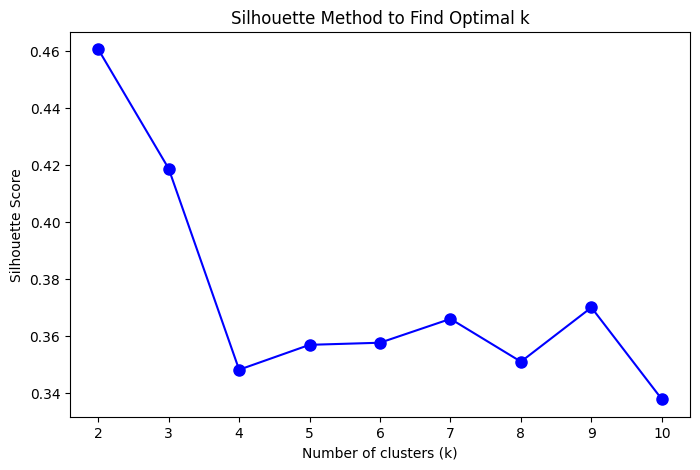

In [58]:
from sklearn.metrics import silhouette_score

# Compute silhouette score for the chosen k
sil_score = silhouette_score(day_pca, day_numeric['cluster'])
print(sil_score)
print(f"Silhouette Score for k={best_k}: {sil_score:.3f}")

sil_scores = []
k_values = range(2, 11)  # silhouette not defined for k=1

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(day_pca)
    score = silhouette_score(day_pca, labels)
    print(f"K = {k} and Score = {score:.2f}")
    sil_scores.append(score)

# Plot Silhouette Scores
plt.figure(figsize=(8,5))
plt.plot(k_values, sil_scores, 'bo-', markersize=8)
plt.xlabel('Number of clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Method to Find Optimal k')
plt.show()

## 7. Interactive Bokeh Cluster Plot

In [62]:
# Prepare data for Bokeh
source = ColumnDataSource(day_numeric)

# Create the figure
p = figure(
    title="Bike-Sharing Clusters (PCA Projection)",
    x_axis_label='PCA1',
    y_axis_label='PCA2',
    tools="pan,wheel_zoom,box_zoom,reset,hover,save",
    width=800, height=500
)

# Choose palette colors
palette = Category10[10]

# Plot each cluster using scatter (replaces circle)
for i in day_numeric['cluster'].unique():
    cluster_data = day_numeric[day_numeric['cluster'] == i]
    cluster_source = ColumnDataSource(cluster_data)
    p.scatter(
        'PCA1', 'PCA2',
        source=cluster_source,
        size=7,        # same as before
        color=palette[i],
        alpha=0.6,
        legend_label=f"Cluster {i}"
    )

# Add hover tool to see feature values
hover = p.select_one(HoverTool)
hover.tooltips = [
    ("Cluster", "@cluster"),
    ("Temp", "@temp"),
    ("Humidity", "@hum"),
    ("Count", "@cnt"),
    ("Season", "@season"),
    ("Weather", "@weathersit")
]

# Legend settings
p.legend.location = "top_right"
p.legend.title = "Clusters"

# Show plot
show(p)


## 8. Alternatives

### Hierarchical Clustering (Agglomerative)

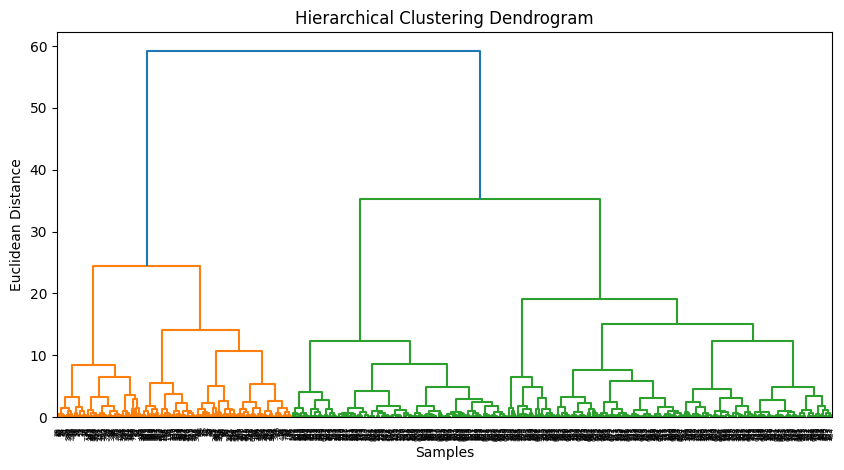

cluster_hc
0    261
2    203
1    143
3     79
4     45
Name: count, dtype: int64


In [65]:
from sklearn.cluster import AgglomerativeClustering
import scipy.cluster.hierarchy as sch

# Dendrogram
plt.figure(figsize=(10, 5))
dendrogram = sch.dendrogram(sch.linkage(day_pca, method='ward'))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Samples')
plt.ylabel('Euclidean Distance')
plt.show()

# Apply Agglomerative Clustering with k=5
hc = AgglomerativeClustering(n_clusters=5, metric='euclidean', linkage='ward')
day_numeric['cluster_hc'] = hc.fit_predict(day_pca)

# Compare cluster sizes
print(day_numeric['cluster_hc'].value_counts())


- 5 clusters, sizes are quite unbalanced.
- Largest cluster: 261 samples, smallest: 45 samples.
- This suggests that some behavior patterns (probably high-demand days) dominate the dataset, while rare patterns (maybe holidays/extreme weather) are smaller clusters.

**Sample differs from that of K-means**

### DBSCAN (Density-Based Clustering)

In [70]:
from sklearn.cluster import DBSCAN

# Dictionary to store results
dbscan_results = {}

# Loop over eps values
eps_values = np.arange(0.1, 1.6, 0.1)

for eps in eps_values:
    dbscan = DBSCAN(eps=eps, min_samples=5)
    labels = dbscan.fit_predict(day_pca)
    
    # Convert to Series for counting
    label_series = pd.Series(labels)
    
    # Count clusters (excluding noise)
    cluster_counts = label_series[label_series != -1].value_counts().to_dict()
    noise_count = (label_series == -1).sum()
    
    # Save summary
    dbscan_results[round(eps, 2)] = {
        'num_clusters': len(cluster_counts),
        'noise_points': noise_count,
        'cluster_sizes': cluster_counts
    }

# Display results nicely
for eps, summary in dbscan_results.items():
    print(f"eps={eps}: clusters={summary['num_clusters']}, noise={summary['noise_points']}, sizes={summary['cluster_sizes']}")


eps=0.1: clusters=10, noise=679, sizes={5: 8, 7: 6, 2: 5, 0: 5, 3: 5, 1: 5, 9: 5, 6: 5, 4: 4, 8: 4}
eps=0.2: clusters=22, noise=279, sizes={10: 256, 12: 34, 14: 23, 20: 14, 6: 12, 13: 11, 9: 10, 8: 10, 15: 8, 0: 7, 3: 7, 4: 7, 5: 6, 11: 6, 17: 6, 1: 5, 2: 5, 7: 5, 16: 5, 18: 5, 19: 5, 21: 5}
eps=0.3: clusters=12, noise=97, sizes={5: 447, 1: 76, 0: 41, 4: 17, 8: 10, 3: 10, 7: 10, 6: 6, 9: 6, 10: 5, 2: 4, 11: 2}
eps=0.4: clusters=2, noise=33, sizes={0: 693, 1: 5}
eps=0.5: clusters=2, noise=10, sizes={0: 713, 1: 8}
eps=0.6: clusters=2, noise=6, sizes={0: 716, 1: 9}
eps=0.7: clusters=2, noise=5, sizes={0: 717, 1: 9}
eps=0.8: clusters=1, noise=2, sizes={0: 729}
eps=0.9: clusters=1, noise=2, sizes={0: 729}
eps=1.0: clusters=1, noise=1, sizes={0: 730}
eps=1.1: clusters=1, noise=1, sizes={0: 730}
eps=1.2: clusters=1, noise=1, sizes={0: 730}
eps=1.3: clusters=1, noise=0, sizes={0: 731}
eps=1.4: clusters=1, noise=0, sizes={0: 731}
eps=1.5: clusters=1, noise=0, sizes={0: 731}


- num_clusters → number of clusters excluding noise labeled as **cluster**.
- noise_points → number of points labeled -1 label as **noise** or **outlier**.
- cluster_sizes → dictionary of cluster label → number of days in that cluster labeled as **sizes**

#### With the change in epsilon there is drastic decrease in cluster between eps 0.3 - 0.4. DBSCAN doesn’t validate k=5

In [40]:
from sklearn.metrics import silhouette_score
from sklearn.metrics import adjusted_rand_score

score_hc = silhouette_score(day_pca, day_numeric['cluster_hc'])
print(f"Silhouette Score (Hierarchical, k=5): {score_hc:.3f}")

ari = adjusted_rand_score(day_numeric['cluster'], day_numeric['cluster_hc'])
print(f"Adjusted Rand Index between K-Means and Hierarchical: {ari:.3f}")

Silhouette Score (Hierarchical, k=5): 0.348
Adjusted Rand Index between K-Means and Hierarchical: 0.569


##### ARI measures agreement between clusterings: 0 = no agreement, 1 = perfect agreement.
- 0.569 is moderate agreement, showing that hierarchical clusters are similar to K-Means clusters but not identical.

## Overall Interpretation
- K-Means clusters (~4–5) and hierarchical clusters (~5) both make sense.
- Silhouette scores are similar, validating your choice.
- DBSCAN isn’t useful here.
- Cluster sizes differ slightly in hierarchical and K-means, but both methods capture the main patterns in bike usage.
  Business insight: Your 5 clusters likely represent:
    - High-demand days (summer, clear weather)
    - Moderate-demand days
    - Low-demand weekdays
    - Weekends or holidays
    - Rare/extreme weather days

## 9. Calculate Cluster Characteristics
- We’ll compute the average bike count (cnt), temperature (temp), humidity (hum), and windspeed per cluster for K-Means clusters.


In [71]:
# Group by K-Means cluster and calculate mean of key features
cluster_summary = day_numeric.groupby('cluster')[['cnt', 'temp', 'hum', 'windspeed']].mean().reset_index()
# Round for readability
cluster_summary = cluster_summary.round(2)
cluster_summary

,cluster,cnt,temp,hum,windspeed
0,0,2357.39,0.37,0.77,0.21
1,1,5100.24,0.46,0.52,0.22
2,2,2219.55,0.26,0.52,0.23
3,3,6343.95,0.68,0.59,0.17
4,4,4741.87,0.53,0.72,0.16


- cnt → average number of bikes rented
- temp → average normalized temperature
- hum → average normalized humidity
- windspeed → average normalized windspeed
#### This gives business insight into each cluster

### Calculate Season Percentages per Cluster

In [110]:
# Create a dataframe for cluster vs season counts
season_cluster = day_numeric.groupby(['cluster', 'season']).size().reset_index(name='count')

# Calculate total days per cluster
total_days = day_numeric.groupby('cluster').size().reset_index(name='total_days')

# Merge to compute percentages
season_cluster = season_cluster.merge(total_days, on='cluster')
season_cluster['percentage'] = (season_cluster['count'] / season_cluster['total_days'] * 100).round(2)

season_cluster

,cluster,season,count,total_days,percentage
0,0,1,35,96,36.46
1,0,2,29,96,30.21
2,0,3,4,96,4.17
3,0,4,28,96,29.17
4,1,1,28,108,25.93
5,1,2,66,108,61.11
6,1,4,14,108,12.96
7,2,1,117,123,95.12
8,2,2,6,123,4.88
9,3,2,46,204,22.55


### Visualize as Stacked Bar Plot (Bokeh)

In [111]:
from bokeh.plotting import figure, show, output_notebook
from bokeh.models import ColumnDataSource, HoverTool
from bokeh.palettes import Category10

output_notebook()

season_map = {'1':'Spring','2': 'Summer','3': 'Fall','4': 'Winter'}

# Pivot table: cluster vs season percentage
stacked_data = season_cluster.pivot(index='cluster', columns='season', values='percentage').fillna(0)

# Convert column names to strings
stacked_data.columns = stacked_data.columns.astype(str)

# Reset index to convert 'cluster' from index to column
stacked_data = stacked_data.reset_index()
stacked_data['cluster_str'] = stacked_data['cluster'].astype(str)  # for categorical x-axis

# Prepare ColumnDataSource
source = ColumnDataSource(stacked_data)


season_map = {'1': 'Spring', '2': 'Summer', '3': 'Fall', '4': 'Winter'}
seasons = stacked_data.columns[1:5]

colors = Category10[4]

p = figure(
    x_range = stacked_data['cluster_str'].tolist(),
    title = "Seasonal Impact (%) per Cluster",
    x_axis_label = "Cluster",
    y_axis_label = "Percentage (%)",
    height = 400,
    width = 700,
    tools = "pan,wheel_zoom,box_zoom,reset,hover,save"
)
p.vbar_stack(
    stackers = seasons,
    x = 'cluster_str',
    width = 0.7,
    color = colors,
    source = source,
    legend_label = [f"Season {s}" for s in seasons]
)

hover = p.select_one(HoverTool)
hover.tooltips = [
    ("Cluster", "@cluster_str"),
    ("Spring (%)", "@1"),
    ("Summer (%)", "@2"),
    ("Fall (%)", "@3"),
    ("Winter (%)", "@4")
]
p.y_range.start = 0
p.y_range.end = 100
p.xgrid.grid_line_color = None
p.axis.minor_tick_line_color = None
p.outline_line_color = None
p.legend.location = "top_right"
p.legend.title = "Seasons"

show(p)


Loading BokehJS ...

#### Season percentage segregation  visualization as per clusters.

In [112]:
# Copy stacked_data for table
table_data = stacked_data.copy()
# Rename season columns from numbers to names
table_data = table_data.rename(columns={'1': 'Spring', '2': 'Summer', '3': 'Fall', '4': 'Winter'})
# Calculate total bike usage per cluster
total_usage = day_numeric.groupby('cluster')['cnt'].sum().reset_index(name='Total_Count')
# Calculate total number of days per cluster
total_days = day_numeric.groupby('cluster').size().reset_index(name='Total_Days')
# Merge both total_usage and total_days into table_data
table_data = table_data.merge(total_usage, on='cluster').merge(total_days, on='cluster')
# Select relevant columns
table_data = table_data[['cluster', 'Spring', 'Summer', 'Fall', 'Winter', 'Total_Days', 'Total_Count']]
# Round percentage values for readability
table_data[['Spring', 'Summer', 'Fall', 'Winter']] = table_data[['Spring', 'Summer', 'Fall', 'Winter']].round(2)

table_data


,cluster,Spring,Summer,Fall,Winter,Total_Days,Total_Count
0,0,36.46,30.21,4.17,29.17,96,226309
1,1,25.93,61.11,0.00,12.96,108,550826
2,2,95.12,4.88,0.00,0.00,123,273005
3,3,0.00,22.55,64.22,13.24,204,1294165
4,4,0.50,18.50,26.50,54.50,200,948374


### Percentage of days in existing clusters 

In [113]:
cluster_summary = []
# Looping each cluster
for cluster_id, group in day_numeric.groupby('cluster'):
    total_days = len(group)
    day_counts = group['weekday'].value_counts().to_dict()
    row = {'cluster': cluster_id, 'Total_Days': total_days}
    for d in range(7):
        count = day_counts.get(d, 0)
        row[str(d)] = round(count / total_days * 100, 2)  # percentage
    cluster_summary.append(row)

# Convert to DataFrame
day_of_week_table = pd.DataFrame(cluster_summary)
cols_order = ['cluster', '1','2','3','4','5','6','0','Total_Days']
day_of_week_table = day_of_week_table[cols_order]
day_of_week_table


,cluster,1,2,3,4,5,6,0,Total_Days
0,0,11.46,14.58,20.83,13.54,11.46,17.71,10.42,96
1,1,13.89,14.81,13.89,14.81,16.67,13.89,12.04,108
2,2,16.26,12.20,11.38,12.20,13.82,14.63,19.51,123
3,3,11.27,14.71,17.16,13.73,15.20,15.69,12.25,204
4,4,18.00,14.50,10.00,16.00,13.50,11.50,16.50,200


In [114]:
source = ColumnDataSource(day_of_week_table)
days = ['1','2','3','4','5','6','0']
colors = Category10[7]

p = figure(
    x_range=[str(c) for c in day_of_week_table['cluster']],
    title="Day-of-Week Distribution per Cluster",
    x_axis_label="Cluster",
    y_axis_label="Percentage of Days (%)",
    width=900,
    height=500,
    tools="pan,wheel_zoom,box_zoom,reset,hover,save"
)

p.vbar_stack(
    stackers=days,
    x='cluster',
    width=0.7,
    color=colors,
    source=source,
    legend_label=[f"Day {d}" for d in days]
)
hover = p.select_one(HoverTool)
hover.tooltips = [
    ("Cluster", "@cluster"),
    ("Day 1 (Mon)", "@1%"),
    ("Day 2 (Tue)", "@2%"),
    ("Day 3 (Wed)", "@3%"),
    ("Day 4 (Thu)", "@4%"),
    ("Day 5 (Fri)", "@5%"),
    ("Day 6 (Sat)", "@6%"),
    ("Day 0 (Sun)", "@0%"),
    ("Total Days", "@Total_Days")
]
p.legend.location = "top_right"
p.legend.title = "Day of Week"
show(p)


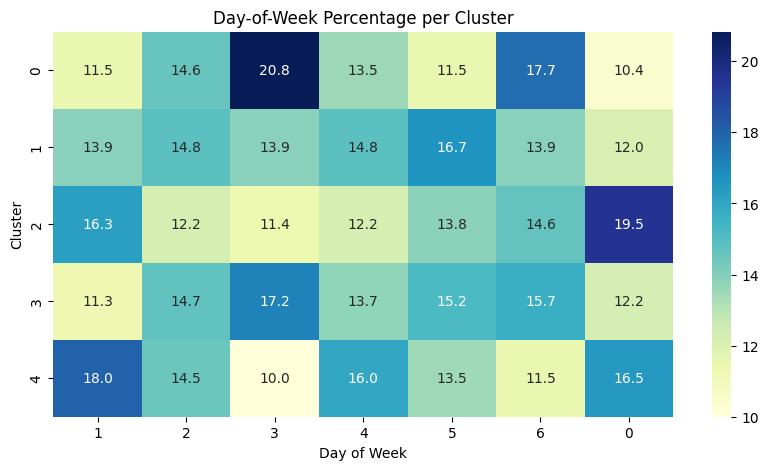

In [115]:
plt.figure(figsize=(10,5))
sns.heatmap(day_of_week_table.set_index('cluster')[['1','2','3','4','5','6','0']],annot=True, fmt=".1f", cmap="YlGnBu")
plt.title("Day-of-Week Percentage per Cluster")
plt.ylabel("Cluster")
plt.xlabel("Day of Week")
plt.show()

### Considering Yearly data distribution percentage in cluster

In [116]:
year_cluster = (
    day_numeric.groupby(['cluster', 'yr'])
    .size()
    .reset_index(name='days_count')
)
total_days_cluster = day_numeric.groupby('cluster').size().reset_index(name='total_days')

year_cluster = year_cluster.merge(total_days_cluster, on='cluster')
year_cluster['percentage'] = (year_cluster['days_count'] / year_cluster['total_days'] * 100).round(2)

# Pivot table for easier view
year_pivot = year_cluster.pivot(index='cluster', columns='yr', values='percentage').fillna(0)
year_pivot.columns = ['2011', '2012']  # Rename for clarity
year_pivot['Total_Days'] = total_days_cluster.set_index('cluster')['total_days']

# Find most and least represented year per cluster
year_cluster_summary = []
for cluster_id, row in year_pivot.iterrows():
    most_year = row[['2011','2012']].idxmax()
    least_year = row[['2011','2012']].idxmin()
    year_cluster_summary.append({
        'cluster': cluster_id,
        '2011 (%)': row['2011'],
        '2012 (%)': row['2012'],
        'Total_Days': row['Total_Days'],
        'Most_Year': most_year,
        'Least_Year': least_year
    })

year_cluster_summary_df = pd.DataFrame(year_cluster_summary)
year_cluster_summary_df

,cluster,2011 (%),2012 (%),Total_Days,Most_Year,Least_Year
0,0,77.08,22.92,96.0,2011,2012
1,1,30.56,69.44,108.0,2012,2011
2,2,60.16,39.84,123.0,2011,2012
3,3,31.37,68.63,204.0,2012,2011
4,4,60.00,40.00,200.0,2011,2012


In [117]:
# Group by cluster and year, sum total bike counts
year_cnt_cluster = (
    day_numeric.groupby(['cluster', 'yr'])['cnt']
    .sum()
    .reset_index()
)
# Pivot for easier view
year_cnt_pivot = year_cnt_cluster.pivot(index='cluster', columns='yr', values='cnt').fillna(0)
year_cnt_pivot.columns = ['2011_Total_Count', '2012_Total_Count']  # Rename for clarity

# Add total count per cluster
year_cnt_pivot['Total_Count'] = year_cnt_pivot['2011_Total_Count'] + year_cnt_pivot['2012_Total_Count']
year_cnt_pivot

,2011_Total_Count,2012_Total_Count,Total_Count
cluster,,,
0,172140,54169,226309
1,136442,414384,550826
2,123761,149244,273005
3,304120,990045,1294165
4,506640,441734,948374


### Cluster_2011 & Cluster_2012
- Total bike counts per cluster for each year
- Line graph compare cluster patterns between 2011 and 2012
- Peaks in the lines show which clusters were busiest in each year

In [118]:
cluster_2011 = day_numeric[day_numeric['yr']==0].groupby('cluster')['cnt'].sum().reset_index()
cluster_2012 = day_numeric[day_numeric['yr']==1].groupby('cluster')['cnt'].sum().reset_index()

# Merge
cluster_merge = cluster_2011.merge(cluster_2012, on='cluster', suffixes=('_2011','_2012'))

# Convert cluster column to string for categorical x-axis
cluster_merge['cluster_str'] = cluster_merge['cluster'].astype(str)
source = ColumnDataSource(cluster_merge)

p = figure(
    title="Cluster-wise Total Bike Count: 2011 vs 2012",
    x_range=cluster_merge['cluster_str'].tolist(),
    x_axis_label='Cluster',
    y_axis_label='Total Bike Count',
    tools="pan,wheel_zoom,box_zoom,reset,hover,save",
    width=800, height=500
)
p.line(x='cluster_str', y='cnt_2011', source=source, line_width=3, color='blue', legend_label='2011')
p.circle(x='cluster_str', y='cnt_2011', source=source, size=8, color='blue', alpha=0.8)
p.line(x='cluster_str', y='cnt_2012', source=source, line_width=3, color='orange', legend_label='2012')
p.circle(x='cluster_str', y='cnt_2012', source=source, size=8, color='orange', alpha=0.8)

hover = p.select_one(HoverTool)
hover.tooltips = [("Cluster", "@cluster_str"),("2011 Count", "@cnt_2011"),("2012 Count", "@cnt_2012")]
p.legend.location = "top_left"
p.legend.click_policy = "hide"
show(p)

# Bike-Sharing Data Clustering Analysis (Hour-Level)

In [119]:
hour = pd.read_csv("hour.csv")
hour_numeric = hour.select_dtypes(include='number')
hour_numeric = hour_numeric.drop(columns=['instant','casual','registered'])

In [120]:
scaler = StandardScaler()
hour_scaled = scaler.fit_transform(hour_numeric)
pca = PCA(n_components=2)
hour_pca = pca.fit_transform(hour_scaled)
hour_numeric['PCA1'] = hour_pca[:,0]
hour_numeric['PCA2'] = hour_pca[:,1]
print("Explained variance ratio:", pca.explained_variance_ratio_)

Explained variance ratio: [0.21053601 0.15464735]


In [122]:
kmeans = KMeans(n_clusters=5, random_state=42)
hour_numeric['cluster'] = kmeans.fit_predict(hour_pca)
print(hour_numeric['cluster'].value_counts())


cluster
3    5051
0    4758
4    2886
2    2609
1    2075
Name: count, dtype: int64


In [124]:
source = ColumnDataSource(hour_numeric)
palette = Category10[10]

p = figure(
    title="Hourly Bike-Sharing Clusters (PCA Projection)",
    x_axis_label='PCA1',
    y_axis_label='PCA2',
    width=800, height=500,
    tools="pan,wheel_zoom,box_zoom,reset,hover,save"
)

for i in hour_numeric['cluster'].unique():
    cluster_data = hour_numeric[hour_numeric['cluster']==i]
    cluster_source = ColumnDataSource(cluster_data)
    p.scatter(
        'PCA1', 'PCA2', source=cluster_source,
        size=7, color=palette[i], alpha=0.6, legend_label=f"Cluster {i}"
    )

hover = p.select_one(HoverTool)
hover.tooltips = [
    ("Cluster", "@cluster"),
    ("Hour", "@hr"),
    ("Temp", "@temp"),
    ("Count", "@cnt")
]

p.legend.location = "top_right"
p.legend.title = "Clusters"

show(p)


In [125]:
# Hourly usage per cluster
hourly_pattern = hour_numeric.groupby(['cluster','hr'])['cnt'].mean().unstack()
hourly_pattern

hr,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
cluster,,,,,,,,,,,,,,,,,,,,,
0,64.829412,40.076696,26.662791,14.081571,7.806548,25.178788,93.871166,230.567273,322.579208,233.889952,...,186.597938,205.891304,248.547619,295.382353,287.886076,243.312500,181.899225,154.129870,122.491018,86.416667
1,51.833333,30.363636,16.800000,9.166667,5.142857,24.818182,99.400000,289.750000,469.971429,249.060606,...,208.632653,214.780822,252.509804,360.434483,317.992857,250.957447,186.913043,152.172932,120.111111,76.707965
2,26.006536,17.487342,12.847682,7.340426,3.034722,10.401274,41.174699,99.218543,174.172131,130.684211,...,85.000000,81.015873,89.333333,134.547170,124.314815,99.300000,75.926829,56.670588,47.958763,33.893204
3,110.933333,48.571429,55.000000,13.750000,11.000000,27.200000,152.222222,408.079208,547.360577,277.588542,...,313.469444,317.598404,397.773537,598.139759,561.012407,427.000000,322.205047,249.014440,195.500000,133.234450
4,52.560000,34.167464,23.705314,11.066986,6.320574,18.271028,67.320000,147.170732,222.736000,184.559055,...,143.775862,160.153846,158.581395,186.775510,186.711538,150.982456,111.709677,97.164557,85.274725,68.138211


In [126]:
# Average count per hour (overall)
avg_hourly_usage = hour_numeric.groupby('hr')['cnt'].mean().reset_index()
avg_hourly_usage.columns = ['Hour', 'Avg_Count']

# Sort to identify peaks
avg_hourly_usage = avg_hourly_usage.sort_values('Avg_Count', ascending=False)
avg_hourly_usage.head(5)


,Hour,Avg_Count
17,17,461.452055
18,18,425.510989
8,8,359.011004
16,16,311.983562
19,19,311.523352


In [127]:
# Average hourly count per cluster
cluster_hourly = hour_numeric.groupby(['cluster', 'hr'])['cnt'].mean().reset_index()
cluster_hourly.columns = ['Cluster', 'Hour', 'Avg_Count']

# Find the hour with highest usage per cluster
peak_hours = cluster_hourly.loc[cluster_hourly.groupby('Cluster')['Avg_Count'].idxmax()].reset_index(drop=True)
peak_hours


,Cluster,Hour,Avg_Count
0,0,8,322.579208
1,1,8,469.971429
2,2,8,174.172131
3,3,17,598.139759
4,4,8,222.736000


In [ ]:
source = ColumnDataSource(cluster_hourly)

p = figure(
    title="Cluster-wise Hourly Bike Usage Patterns",
    x_axis_label='Hour of Day',
    y_axis_label='Average Count',
    width=850, height=500,
    tools="pan,wheel_zoom,box_zoom,reset,hover,save"
)
palette = Category10[10]

for cluster_id in sorted(hour_numeric['cluster'].unique()):
    cluster_data = cluster_hourly[cluster_hourly['Cluster'] == cluster_id]
    p.line(
        x='Hour', y='Avg_Count', source=ColumnDataSource(cluster_data),
        color=palette[cluster_id], line_width=3, alpha=0.8, legend_label=f"Cluster {cluster_id}"
    )
    p.scatter(
        x='Hour', y='Avg_Count', source=ColumnDataSource(cluster_data),
        color=palette[cluster_id], size=6, alpha=0.7
    )

hover = p.select_one(HoverTool)
hover.tooltips = [("Cluster", "@Cluster"), ("Hour", "@Hour"), ("Avg Count", "@Avg_Count")]

p.legend.location = "top_left"
p.legend.title = "Clusters"

show(p)
from bokeh.models import ColumnDataSource, HoverTool, LabelSet

In [132]:
from bokeh.models import LabelSet

cluster_hourly = hour_numeric.groupby(['cluster', 'hr'])['cnt'].mean().reset_index()
cluster_hourly.columns = ['Cluster', 'Hour', 'Avg_Count']

peak_hours = cluster_hourly.loc[cluster_hourly.groupby('Cluster')['Avg_Count'].idxmax()].reset_index(drop=True)
peak_hours['Cluster_str'] = peak_hours['Cluster'].astype(str)

source = ColumnDataSource(cluster_hourly)
peak_source = ColumnDataSource(peak_hours)

p = figure(
    title="Peak Hour Identification per Cluster",
    x_axis_label="Hour of the Day",
    y_axis_label="Average Bike Count",
    width=850,
    height=450,
    tools="pan,wheel_zoom,box_zoom,reset,hover,save"
)
colors = Category10[10]
for i, cluster in enumerate(cluster_hourly['Cluster'].unique()):
    cluster_data = cluster_hourly[cluster_hourly['Cluster'] == cluster]
    cluster_src = ColumnDataSource(cluster_data)
    
    p.line(
        x='Hour', y='Avg_Count',
        source=cluster_src,
        color=colors[i % len(colors)],
        line_width=2,
        legend_label=f"Cluster {cluster}"
    )
    p.scatter(
        x='Hour', y='Avg_Count',
        source=cluster_src,
        color=colors[i % len(colors)],
        size=6,
        alpha=0.8
    )
p.scatter(
    x='Hour', y='Avg_Count',
    source=peak_source,
    color='red', size=12, alpha=0.9, marker='star',
    legend_label='Peak Hour'
)
labels = LabelSet(
    x='Hour', y='Avg_Count', text='Cluster_str', level='glyph',
    x_offset=8, y_offset=8, source=peak_source,
    text_font_size='10pt', text_color='red'
)
p.add_layout(labels)

hover = p.select_one(HoverTool)
hover.tooltips = [
    ("Cluster", "@Cluster_str"),
    ("Hour", "@Hour"),
    ("Avg Count", "@Avg_Count{0.0}")
]
p.legend.title = "Clusters"
p.legend.location = "top_left"
p.legend.click_policy = "hide"
show(p)
